In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys

src_dir = Path.cwd().parent.absolute()
sys.path.append(str(src_dir))

from src.data import get_train_val_dataloaders, IMAGENET_MEAN, IMAGENET_STD

In [2]:
import os
os.environ["LIGHTNING_DISABLE_TIPS"] = "1"

In [3]:
train_loader, val_loader = get_train_val_dataloaders(
    batch_size=256,
    num_workers=4,
)

In [4]:
def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

In [5]:
def sample_by_class(dataloader, num_pos=4, num_neg=4):
    pos_imgs = []
    neg_imgs = []

    for imgs, labels in dataloader:
        for img, label in zip(imgs, labels):
            if label.item() == 1 and len(pos_imgs) < num_pos:
                pos_imgs.append(img)
            elif label.item() == 0 and len(neg_imgs) < num_neg:
                neg_imgs.append(img)

        if len(pos_imgs) == num_pos and len(neg_imgs) == num_neg:
            break

    return pos_imgs, neg_imgs

In [6]:
pos_samples, neg_samples = sample_by_class(train_loader)

In [7]:
def show_images(title, images):
    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))
    fig.suptitle(title, fontsize=16)

    for ax, img in zip(axes, images):
        ax.imshow(denormalize(img))
        ax.axis("off")

    plt.show()

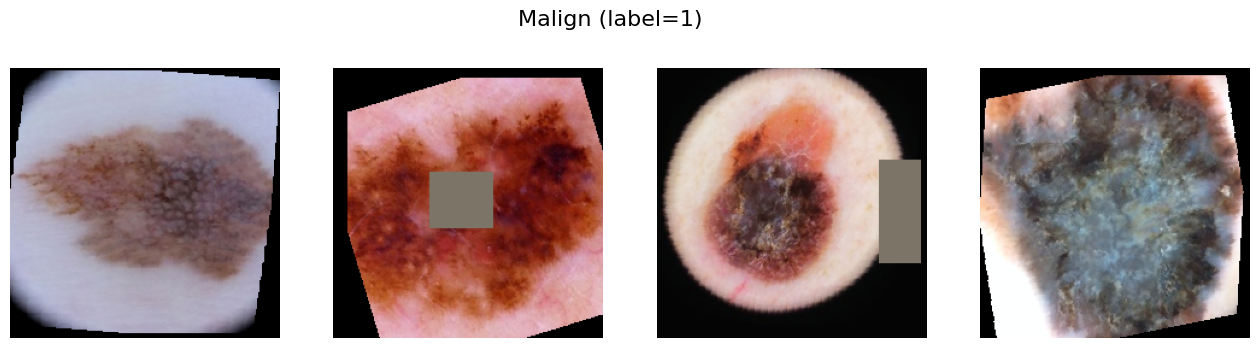

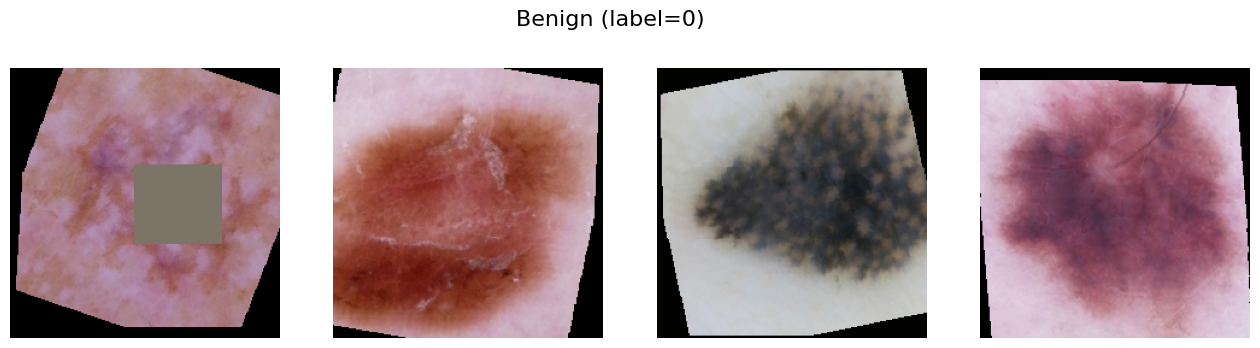

In [8]:
show_images("Malign (label=1)", pos_samples)
show_images("Benign (label=0)", neg_samples)

In [9]:
len(train_loader.dataset), len(val_loader.dataset)

(20331, 2500)

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.GELU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.GELU(),

            nn.MaxPool2d(kernel_size=2, stride=stride)
        )

    def forward(self, x):
        return self.block(x)


class MelanomaBaselineCNN(nn.Module):
    """A reasonable baseline CNN for ISIC binary classification."""
    def __init__(self, num_classes=1):
        super().__init__()

        self.features = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=32, kernel_size=5),
            ConvBlock(in_channels=32, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
import math

import pytorch_lightning as pl
import torch
import torch.nn as nn
from sklearn.metrics import balanced_accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR


class MelanomaLitModule(pl.LightningModule):
    """
    Model agnostic LightningModule for melanoma classification.

    Configurable training hyperparameters via config dict.
    """

    def __init__(
        self,
        model: nn.Module,
        config: dict,
    ):
        super().__init__()
        self.model = model
        self.save_hyperparameters(config)

        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_preds = []
        self.train_targets = []

        self.val_preds = []
        self.val_targets = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        logits = self(images).squeeze(1)

        preds = (torch.sigmoid(logits) > 0.5).long()
        self.train_preds.append(preds.cpu())
        self.train_targets.append(targets.cpu())

        loss = self.loss_fn(logits, targets.float())
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)

        return loss

    def on_train_epoch_end(self):
        preds = torch.cat(self.train_preds).numpy()
        targets = torch.cat(self.train_targets).numpy()

        bal_acc = balanced_accuracy_score(targets, preds)

        self.log("train_balanced_accuracy", bal_acc, prog_bar=True)

        self.train_preds.clear()
        self.train_targets.clear()

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        logits = self(images).squeeze(1)

        loss = self.loss_fn(logits, targets.float())
        preds = (torch.sigmoid(logits) > 0.5).long()

        self.val_preds.append(preds.cpu())
        self.val_targets.append(targets.cpu())

        self.log("val_loss", loss, prog_bar=True, on_epoch=True)

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_preds).numpy()
        targets = torch.cat(self.val_targets).numpy()

        bal_acc = balanced_accuracy_score(targets, preds)
        self.log("val_balanced_accuracy", bal_acc, prog_bar=True)

        self.val_preds.clear()
        self.val_targets.clear()

    def configure_optimizers(self):
        learning_rate = self.hparams.get("learning_rate", 1e-3)
        weight_decay = self.hparams.get("weight_decay", 1e-4)
        warmup_epochs = self.hparams.get("warmup_epochs", 5)
        max_epochs = self.hparams.get("max_epochs", 50)

        optimizer = AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
        )

        def lr_lambda(current_epoch):
            if current_epoch < warmup_epochs:
                return float(current_epoch) / float(max(1, warmup_epochs))

            progress = (current_epoch - warmup_epochs) / float(
                max(1, max_epochs - warmup_epochs)
            )

            return 0.5 * (1.0 + torch.cos(torch.tensor(progress * math.pi)))

        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
            },
        }

In [12]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

model = MelanomaBaselineCNN(num_classes=1)
config = dict(
    learning_rate=5e-4,
    weight_decay=5e-4,
    warmup_epochs=5,
    max_epochs=50,
    use_scheduler=True,
)
lit_model = MelanomaLitModule(model, config)

ckpt_dir = Path.cwd() / "checkpoints"
ckpt_dir.mkdir(parents=True, exist_ok=True)

ckpt_best = ModelCheckpoint(
    dirpath=ckpt_dir,
    filename="best",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    save_last=False,
    verbose=True,
)
ckpt_last = ModelCheckpoint(
    dirpath=ckpt_dir,
    filename="last",
    save_top_k=1,
    every_n_epochs=1,
    verbose=True,
)

trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1,
    callbacks=[ckpt_best, ckpt_last],
    precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
)

trainer.fit(lit_model, train_loader, val_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 5070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/gener

Epoch 0: 100%|██████████| 80/80 [00:22<00:00,  3.48it/s, v_num=7, train_loss_step=0.700, val_loss=0.704, val_balanced_accuracy=0.462, train_loss_epoch=0.702]

Epoch 0, global step 80: 'val_loss' reached 0.70395 (best 0.70395), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 1: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.364, val_loss=0.418, val_balanced_accuracy=0.597, train_loss_epoch=0.432, train_balanced_accuracy=0.488]

Epoch 1, global step 160: 'val_loss' reached 0.41800 (best 0.41800), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 2: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=7, train_loss_step=0.415, val_loss=0.419, val_balanced_accuracy=0.681, train_loss_epoch=0.390, train_balanced_accuracy=0.527]

Epoch 2, global step 240: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 80/80 [00:22<00:00,  3.56it/s, v_num=7, train_loss_step=0.309, val_loss=0.395, val_balanced_accuracy=0.650, train_loss_epoch=0.383, train_balanced_accuracy=0.579]

Epoch 3, global step 320: 'val_loss' reached 0.39498 (best 0.39498), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 4: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=7, train_loss_step=0.454, val_loss=0.373, val_balanced_accuracy=0.598, train_loss_epoch=0.378, train_balanced_accuracy=0.592]

Epoch 4, global step 400: 'val_loss' reached 0.37254 (best 0.37254), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 5: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.383, val_loss=0.379, val_balanced_accuracy=0.629, train_loss_epoch=0.377, train_balanced_accuracy=0.601]

Epoch 5, global step 480: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.402, val_loss=0.379, val_balanced_accuracy=0.605, train_loss_epoch=0.373, train_balanced_accuracy=0.605]

Epoch 6, global step 560: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.424, val_loss=0.370, val_balanced_accuracy=0.673, train_loss_epoch=0.369, train_balanced_accuracy=0.604]

Epoch 7, global step 640: 'val_loss' reached 0.36995 (best 0.36995), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 8: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.332, val_loss=0.362, val_balanced_accuracy=0.635, train_loss_epoch=0.365, train_balanced_accuracy=0.613]

Epoch 8, global step 720: 'val_loss' reached 0.36190 (best 0.36190), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 9: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.448, val_loss=0.360, val_balanced_accuracy=0.662, train_loss_epoch=0.367, train_balanced_accuracy=0.616]

Epoch 9, global step 800: 'val_loss' reached 0.36040 (best 0.36040), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 10: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s, v_num=7, train_loss_step=0.404, val_loss=0.368, val_balanced_accuracy=0.636, train_loss_epoch=0.356, train_balanced_accuracy=0.619]

Epoch 10, global step 880: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.318, val_loss=0.378, val_balanced_accuracy=0.676, train_loss_epoch=0.359, train_balanced_accuracy=0.626]

Epoch 11, global step 960: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s, v_num=7, train_loss_step=0.385, val_loss=0.357, val_balanced_accuracy=0.608, train_loss_epoch=0.359, train_balanced_accuracy=0.631]

Epoch 12, global step 1040: 'val_loss' reached 0.35743 (best 0.35743), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 13: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.307, val_loss=0.376, val_balanced_accuracy=0.605, train_loss_epoch=0.357, train_balanced_accuracy=0.626]

Epoch 13, global step 1120: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.339, val_loss=0.348, val_balanced_accuracy=0.642, train_loss_epoch=0.354, train_balanced_accuracy=0.629]

Epoch 14, global step 1200: 'val_loss' reached 0.34786 (best 0.34786), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 15: 100%|██████████| 80/80 [00:22<00:00,  3.51it/s, v_num=7, train_loss_step=0.297, val_loss=0.355, val_balanced_accuracy=0.608, train_loss_epoch=0.351, train_balanced_accuracy=0.627]

Epoch 15, global step 1280: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.402, val_loss=0.349, val_balanced_accuracy=0.688, train_loss_epoch=0.350, train_balanced_accuracy=0.632]

Epoch 16, global step 1360: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.415, val_loss=0.351, val_balanced_accuracy=0.696, train_loss_epoch=0.348, train_balanced_accuracy=0.639]

Epoch 17, global step 1440: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.405, val_loss=0.356, val_balanced_accuracy=0.653, train_loss_epoch=0.347, train_balanced_accuracy=0.635]

Epoch 18, global step 1520: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.381, val_loss=0.351, val_balanced_accuracy=0.657, train_loss_epoch=0.344, train_balanced_accuracy=0.638]

Epoch 19, global step 1600: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.380, val_loss=0.337, val_balanced_accuracy=0.621, train_loss_epoch=0.343, train_balanced_accuracy=0.641]

Epoch 20, global step 1680: 'val_loss' reached 0.33722 (best 0.33722), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 21: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s, v_num=7, train_loss_step=0.342, val_loss=0.338, val_balanced_accuracy=0.651, train_loss_epoch=0.339, train_balanced_accuracy=0.648]

Epoch 21, global step 1760: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.386, val_loss=0.337, val_balanced_accuracy=0.658, train_loss_epoch=0.339, train_balanced_accuracy=0.649]

Epoch 22, global step 1840: 'val_loss' reached 0.33682 (best 0.33682), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 23: 100%|██████████| 80/80 [00:22<00:00,  3.50it/s, v_num=7, train_loss_step=0.415, val_loss=0.352, val_balanced_accuracy=0.600, train_loss_epoch=0.337, train_balanced_accuracy=0.650]

Epoch 23, global step 1920: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s, v_num=7, train_loss_step=0.367, val_loss=0.349, val_balanced_accuracy=0.650, train_loss_epoch=0.335, train_balanced_accuracy=0.659]

Epoch 24, global step 2000: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.264, val_loss=0.341, val_balanced_accuracy=0.688, train_loss_epoch=0.333, train_balanced_accuracy=0.654]

Epoch 25, global step 2080: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.310, val_loss=0.337, val_balanced_accuracy=0.681, train_loss_epoch=0.330, train_balanced_accuracy=0.659]

Epoch 26, global step 2160: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s, v_num=7, train_loss_step=0.299, val_loss=0.333, val_balanced_accuracy=0.672, train_loss_epoch=0.329, train_balanced_accuracy=0.661]

Epoch 27, global step 2240: 'val_loss' reached 0.33304 (best 0.33304), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 28: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, v_num=7, train_loss_step=0.317, val_loss=0.333, val_balanced_accuracy=0.665, train_loss_epoch=0.330, train_balanced_accuracy=0.665]

Epoch 28, global step 2320: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.319, val_loss=0.327, val_balanced_accuracy=0.667, train_loss_epoch=0.325, train_balanced_accuracy=0.661]

Epoch 29, global step 2400: 'val_loss' reached 0.32726 (best 0.32726), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 30: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=7, train_loss_step=0.375, val_loss=0.339, val_balanced_accuracy=0.664, train_loss_epoch=0.324, train_balanced_accuracy=0.669]

Epoch 30, global step 2480: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=7, train_loss_step=0.303, val_loss=0.345, val_balanced_accuracy=0.700, train_loss_epoch=0.320, train_balanced_accuracy=0.671]

Epoch 31, global step 2560: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=7, train_loss_step=0.384, val_loss=0.325, val_balanced_accuracy=0.670, train_loss_epoch=0.317, train_balanced_accuracy=0.672]

Epoch 32, global step 2640: 'val_loss' reached 0.32494 (best 0.32494), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 33: 100%|██████████| 80/80 [00:22<00:00,  3.61it/s, v_num=7, train_loss_step=0.325, val_loss=0.334, val_balanced_accuracy=0.714, train_loss_epoch=0.316, train_balanced_accuracy=0.679]

Epoch 33, global step 2720: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 80/80 [00:21<00:00,  3.72it/s, v_num=7, train_loss_step=0.366, val_loss=0.325, val_balanced_accuracy=0.666, train_loss_epoch=0.313, train_balanced_accuracy=0.682]

Epoch 34, global step 2800: 'val_loss' reached 0.32479 (best 0.32479), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 35: 100%|██████████| 80/80 [00:21<00:00,  3.74it/s, v_num=7, train_loss_step=0.254, val_loss=0.326, val_balanced_accuracy=0.693, train_loss_epoch=0.310, train_balanced_accuracy=0.682]

Epoch 35, global step 2880: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 80/80 [00:21<00:00,  3.74it/s, v_num=7, train_loss_step=0.264, val_loss=0.325, val_balanced_accuracy=0.671, train_loss_epoch=0.307, train_balanced_accuracy=0.683]

Epoch 36, global step 2960: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 80/80 [00:21<00:00,  3.74it/s, v_num=7, train_loss_step=0.292, val_loss=0.331, val_balanced_accuracy=0.690, train_loss_epoch=0.306, train_balanced_accuracy=0.692]

Epoch 37, global step 3040: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 80/80 [00:21<00:00,  3.72it/s, v_num=7, train_loss_step=0.310, val_loss=0.323, val_balanced_accuracy=0.657, train_loss_epoch=0.303, train_balanced_accuracy=0.695]

Epoch 38, global step 3120: 'val_loss' reached 0.32318 (best 0.32318), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 39: 100%|██████████| 80/80 [00:21<00:00,  3.73it/s, v_num=7, train_loss_step=0.325, val_loss=0.323, val_balanced_accuracy=0.685, train_loss_epoch=0.300, train_balanced_accuracy=0.696]

Epoch 39, global step 3200: 'val_loss' reached 0.32297 (best 0.32297), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 40: 100%|██████████| 80/80 [00:21<00:00,  3.75it/s, v_num=7, train_loss_step=0.301, val_loss=0.326, val_balanced_accuracy=0.731, train_loss_epoch=0.297, train_balanced_accuracy=0.703]

Epoch 40, global step 3280: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 80/80 [00:21<00:00,  3.72it/s, v_num=7, train_loss_step=0.278, val_loss=0.315, val_balanced_accuracy=0.703, train_loss_epoch=0.295, train_balanced_accuracy=0.706]

Epoch 41, global step 3360: 'val_loss' reached 0.31541 (best 0.31541), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 42: 100%|██████████| 80/80 [00:21<00:00,  3.73it/s, v_num=7, train_loss_step=0.293, val_loss=0.312, val_balanced_accuracy=0.698, train_loss_epoch=0.292, train_balanced_accuracy=0.706]

Epoch 42, global step 3440: 'val_loss' reached 0.31218 (best 0.31218), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 43: 100%|██████████| 80/80 [00:21<00:00,  3.75it/s, v_num=7, train_loss_step=0.236, val_loss=0.313, val_balanced_accuracy=0.699, train_loss_epoch=0.291, train_balanced_accuracy=0.716]

Epoch 43, global step 3520: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 80/80 [00:21<00:00,  3.72it/s, v_num=7, train_loss_step=0.241, val_loss=0.309, val_balanced_accuracy=0.689, train_loss_epoch=0.288, train_balanced_accuracy=0.709]

Epoch 44, global step 3600: 'val_loss' reached 0.30914 (best 0.30914), saving model to '/home/g173317@rsrch.cepetro.unicamp.br/Documents/mdc-melanoma-tbdt/notebooks/checkpoints/best-v2.ckpt' as top 1


Epoch 45: 100%|██████████| 80/80 [00:21<00:00,  3.73it/s, v_num=7, train_loss_step=0.236, val_loss=0.310, val_balanced_accuracy=0.703, train_loss_epoch=0.287, train_balanced_accuracy=0.719]

Epoch 45, global step 3680: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 80/80 [00:21<00:00,  3.73it/s, v_num=7, train_loss_step=0.211, val_loss=0.310, val_balanced_accuracy=0.705, train_loss_epoch=0.286, train_balanced_accuracy=0.712]

Epoch 46, global step 3760: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 80/80 [00:21<00:00,  3.74it/s, v_num=7, train_loss_step=0.295, val_loss=0.309, val_balanced_accuracy=0.698, train_loss_epoch=0.286, train_balanced_accuracy=0.719]

Epoch 47, global step 3840: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 80/80 [00:21<00:00,  3.73it/s, v_num=7, train_loss_step=0.336, val_loss=0.310, val_balanced_accuracy=0.705, train_loss_epoch=0.282, train_balanced_accuracy=0.720]

Epoch 48, global step 3920: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 80/80 [00:21<00:00,  3.74it/s, v_num=7, train_loss_step=0.227, val_loss=0.310, val_balanced_accuracy=0.702, train_loss_epoch=0.284, train_balanced_accuracy=0.716]

Epoch 49, global step 4000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 80/80 [00:21<00:00,  3.72it/s, v_num=7, train_loss_step=0.227, val_loss=0.310, val_balanced_accuracy=0.702, train_loss_epoch=0.284, train_balanced_accuracy=0.716]
